# **Analyse et Prédiction du Risque de Crédit**

Dans le climat économique actuel, l'analyse du risque de crédit est plus pertinente que jamais. Les institutions financières sont continuellement confrontées au défi de distinguer les bons emprunteurs des mauvais pour minimiser les pertes tout en maximisant les opportunités de revenus.

**Objectif** :

L'objectif de ce projet était de développer un modèle prédictif capable de classer les statuts de compte courant des clients en "bon" ou "mauvais" en fonction de leur risque de crédit. En utilisant un ensemble de données comprenant 1000 clients.  nous avons appliqué plusieurs techniques de modélisation statistique, dont la Régression Logistique et XGBoost, pour prédire le risque.


**Impact Attendu**

Le résultat de ce projet a le potentiel de transformer significativement la façon dont les prêteurs évaluent les risques, en réduisant les pertes dues aux défaillances de crédit et en optimisant les processus de décision de prêt.

**Approche et Méthodologie**

Nous avons commencé par une analyse exploratoire des données pour comprendre les caractéristiques et les tendances. Nous avons ensuite prétraité les données, appliqué des techniques de rééquilibrage comme SMOTE pour gérer les déséquilibres des classes, et finalement, mis en œuvre et optimisé plusieurs modèles de machine learning.


In [1]:
import os
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler

from scipy.stats import chi2_contingency


%matplotlib inline
sns.set_theme(color_codes=True)

warnings.filterwarnings('ignore')

## ANALYSE EXPLORATOIRE DES DONNEES 

1- Les données

In [2]:
path = os.getcwd()
chemin_repertoire = os.path.join(path, '../Data')

# chemin fichier
chemin_data = os.path.join(chemin_repertoire, 'Credit_cleaned.csv')

In [3]:
df = pd.read_csv(chemin_data)
df.head() 

,Durations,Credit history,Credit_Purpose,Credit amount,Installment_Rate_Percent,Other debtors / guarantors,Residence_Years,Property,Age in years,Other_Inst_Plans,...,Num_Existing_Credits,Job,Liable_People,Telephone,Foreign worker,Checking_Account_Status,Gender,Status,Years_Employments,Saving_Status
0,6,critical/other existing credit,radio/tv,1169,4,none,4,real estate,67,none,...,2,skilled,1,yes,yes,good,male,single,7 or more years,no savings
1,48,existing paid,radio/tv,5951,2,none,2,real estate,22,none,...,1,skilled,1,none,yes,bad,female,div/dep/mar,1-3 years,less than 100
2,12,critical/other existing credit,education,2096,2,none,3,real estate,49,none,...,1,unskilled_resident,2,none,yes,good,male,single,4-6 years,less than 100
3,42,existing paid,furniture/equipment,7882,2,guarantor,4,life insurance,45,none,...,1,skilled,2,none,yes,good,male,single,4-6 years,less than 100
4,24,delayed previously,new car,4870,3,none,4,no known property,53,none,...,2,skilled,2,none,yes,bad,male,single,1-3 years,less than 100


In [4]:
#df.info()

Notre dataset contient 1000 observations et 21 variables, avec :

- 7 variables numériques (Durations, Credit amount, Age in years...).
- 14 variables catégorielles (Credit history, Property, Gender...).
- 1 variable cible probable (Checking_Account_Status )

2- Les valeurs manquantes

In [5]:
df.isnull().sum().to_frame().T

,Durations,Credit history,Credit_Purpose,Credit amount,Installment_Rate_Percent,Other debtors / guarantors,Residence_Years,Property,Age in years,Other_Inst_Plans,...,Num_Existing_Credits,Job,Liable_People,Telephone,Foreign worker,Checking_Account_Status,Gender,Status,Years_Employments,Saving_Status
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Notre base de données est complète, sans valeurs manquantes.

### Statistiques et analyse univarié

1- Les variables numériques

In [6]:
df.describe()

,Durations,Credit amount,Installment_Rate_Percent,Residence_Years,Age in years,Num_Existing_Credits,Liable_People
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


- **Durations**:  La durée du credit est en moyenne de 21 mois ce qui indique que la majorité des crédits ont une durée inférieure à 2 ans.
- **Credit amount**: Le montant du crédit est en moyenne de **3271**. Le montant minimum est de **250**, tandis que le montant maximal atteint **18 424**. La médiane est de **2 319**, ce qui signifie que la moitié des crédits accordés sont inférieurs à ce montant, tandis que l'autre moitié est supérieure.
- **Installment_Rate_Percent**: Le taux d'écheance en % du revenu est en moyenne de 2,97 % et un écart-type de 1,12 qui traduit une faible variabilité du taux.
La majorité des crédits  ont un taux entre 2% et 4%, ce qui pourrait signifier un seuil réglementaire ou une politique de prêt standardisée.
- **Residence_Years**: La mojorité des emprunteurs résident depuis 2 ou 4ans à la même adresse, indiquant un critère de stabilité financière.
- **Age in years**: L'âge moyen d'un emprunteur est de **35**ans, avec l'âge minimum est de 19ans tandis que l'âge maximum est de 75ans. Les emprunteurs sont principalement des aldultes d'âge moyen, mais l'étendue va de jeunes à des seniors.
- **Num_Existing_Credits**: Le nombre de crédits existants est en moyen de 1,4. La plupart des clients ont 1 ou 2 creédits en cours.

- **Liable_People**: (Personnes à charge) La majorité des emprunteurs ont Une (1) personne à charge, avec un maximum de 2.

En somme:

Crédits majoritairement courts (≤ 2 ans) mais avec quelques prêts longs (jusqu'à 6 ans).

Montants très variables avec une asymétrie probable due aux valeurs élevées.

Taux d’échéance relativement stable (entre 2% et 4% du revenu).
Clients généralement jeunes ou d’âge moyen (19 à 75 ans, avec une médiane autour de 33 ans).

Peu de crédits existants simultanément (généralement 1 ou 2).

Stabilité de résidence relativement courte (≤ 4 ans en moyenne).
Peu de personnes à charge (1 ou 2 max).

In [11]:
#tab =df.describe()
#tab.to_markdown

**Visualisation des numériques**

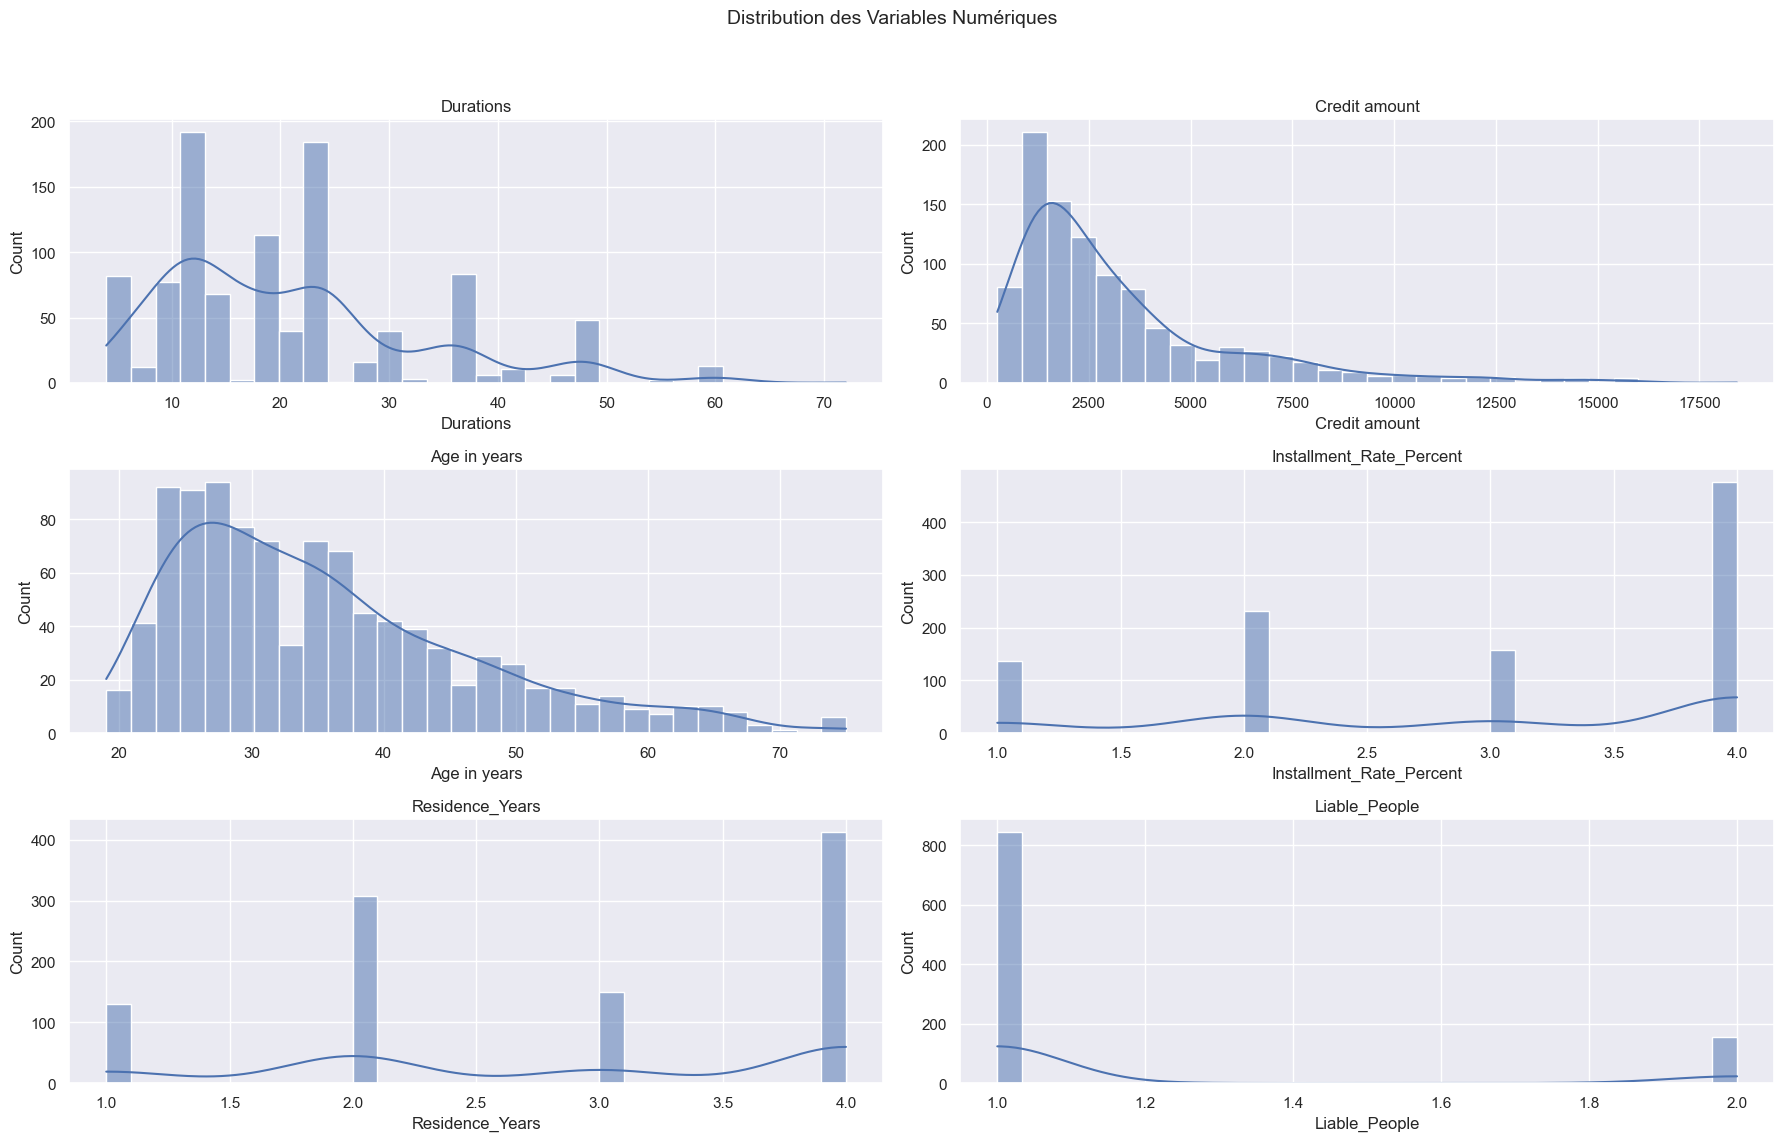

In [13]:
# Visualisation des distributions des variables numériques
fig, axes = plt.subplots(3, 2, figsize=(18, 12))
fig.suptitle("Distribution des Variables Numériques", fontsize=14)

num_vars = ["Durations", "Credit amount", "Age in years", "Installment_Rate_Percent", "Residence_Years", "Liable_People"]
for i, var in enumerate(num_vars):
    sns.histplot(df[var], bins=30, kde=True, ax=axes[i // 2, i % 2])
    axes[i // 2, i % 2].set_title(var)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

2- Les variables catégorielles

In [15]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns

# Afficher la liste des colonnes catégorielles
#print(categorical_columns)

- La variable cible **Checking_Account_Status**

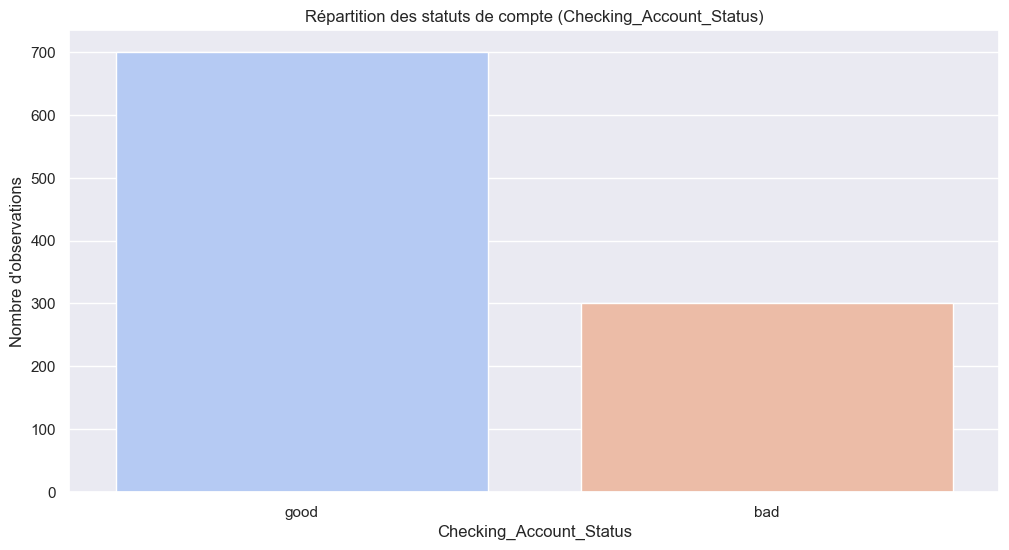

In [36]:
# Distribution de la variable cible "Checking_Account_Status"
plt.figure(figsize=(12, 6))
sns.countplot(x=df["Checking_Account_Status"], palette="coolwarm")
plt.title("Répartition des statuts de compte (Checking_Account_Status)")
plt.xlabel("Checking_Account_Status")
plt.ylabel("Nombre d'observations")
plt.show()

- Il semble y avoir plus de clients "Good" que de clients "Bad".
- Cela signifie que notre dataset est légèrement déséquilibré, ce qui peut affecter la performance du modèle.

- Le status marital (status) set Le Genre (Gender)

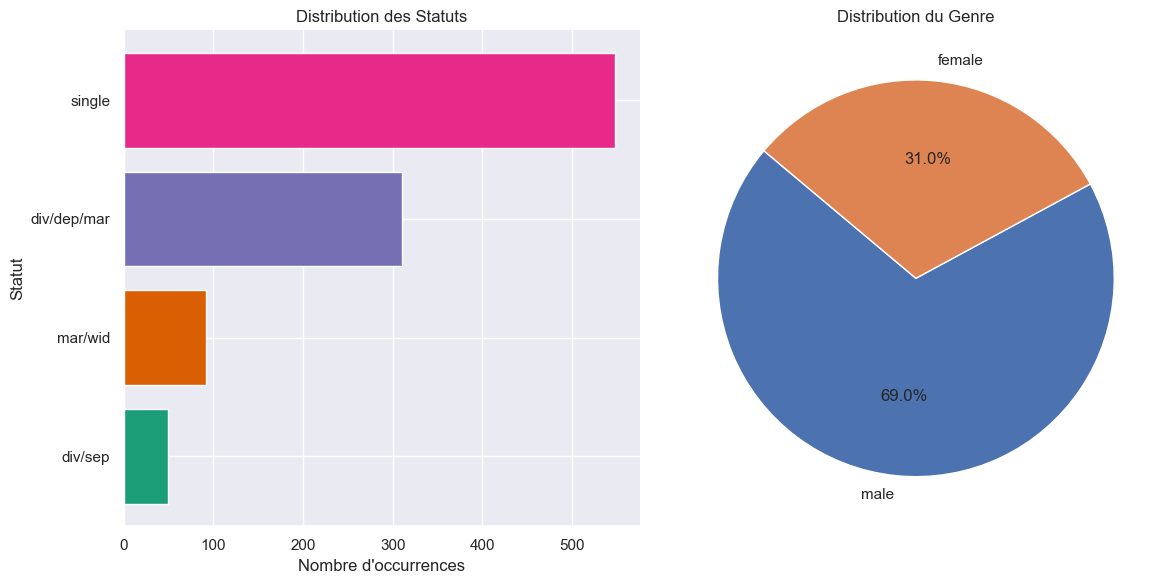

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Premier graphique : Distribution des Statuts (Barres horizontales)
status_counts = df['Status'].value_counts(ascending=True)
axes[0].barh(status_counts.index, status_counts.values, color=sns.color_palette('Dark2', len(status_counts)))
axes[0].set_title("Distribution des Statuts")
axes[0].set_xlabel("Nombre d'occurrences")
axes[0].set_ylabel("Statut")
axes[0].spines[['top', 'right']].set_visible(False)  # Supprimer les bordures inutiles

# Deuxième graphique : Distribution du Genre (Camembert)
gender_counts = df['Gender'].value_counts()
axes[1].pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140)
axes[1].set_title("Distribution du Genre")

# Affichage des graphiques côte à côte
plt.tight_layout()
plt.show()

**Distribution de status(matrimoniale)**
- la catégorie "single" (célibataire) est la plus fréquente avec le plus grand nombre d'occurrences (548).
- la catégorie "div/dep/mar" (divorcé, séparé, marié) suit en termes de fréquences(310).
- "mar/wid" (marié/veuf) 92 et "div/sep" (divorcé/séparé) 50 sont beaucoup moins représenté dans notre échantillon.

**Distribution du genre (sexe)**
- 69% des individus sont de sexe masculin("male")
- 31% des individus sont de sexe féminin("female").

La population analysée contient en majorité les individus de sexe masculin.
Le statut matrimonial majoritaire est "single" célibataire, ce qui indique une population relativement jeune ou/avec une forte proportion de célibataire.  

**Distribution des autres variables catégorielles**

In [21]:
Job_counts = df['Job'].value_counts(ascending=True)

Credit_history_counts = df['Credit history'].value_counts(ascending=True)

Housing_counts = df['Housing'].value_counts(ascending=True)

Checking_Account_Status_counts = df['Checking_Account_Status'].value_counts(ascending=True)

Years_Employments_counts = df['Years_Employments'].value_counts(ascending=True)

Saving_Status_counts = df['Saving_Status'].value_counts(ascending=True)

Property_counts = df['Property'].value_counts(ascending=True)

# print(Job_counts)

#print(Credit_history_counts)

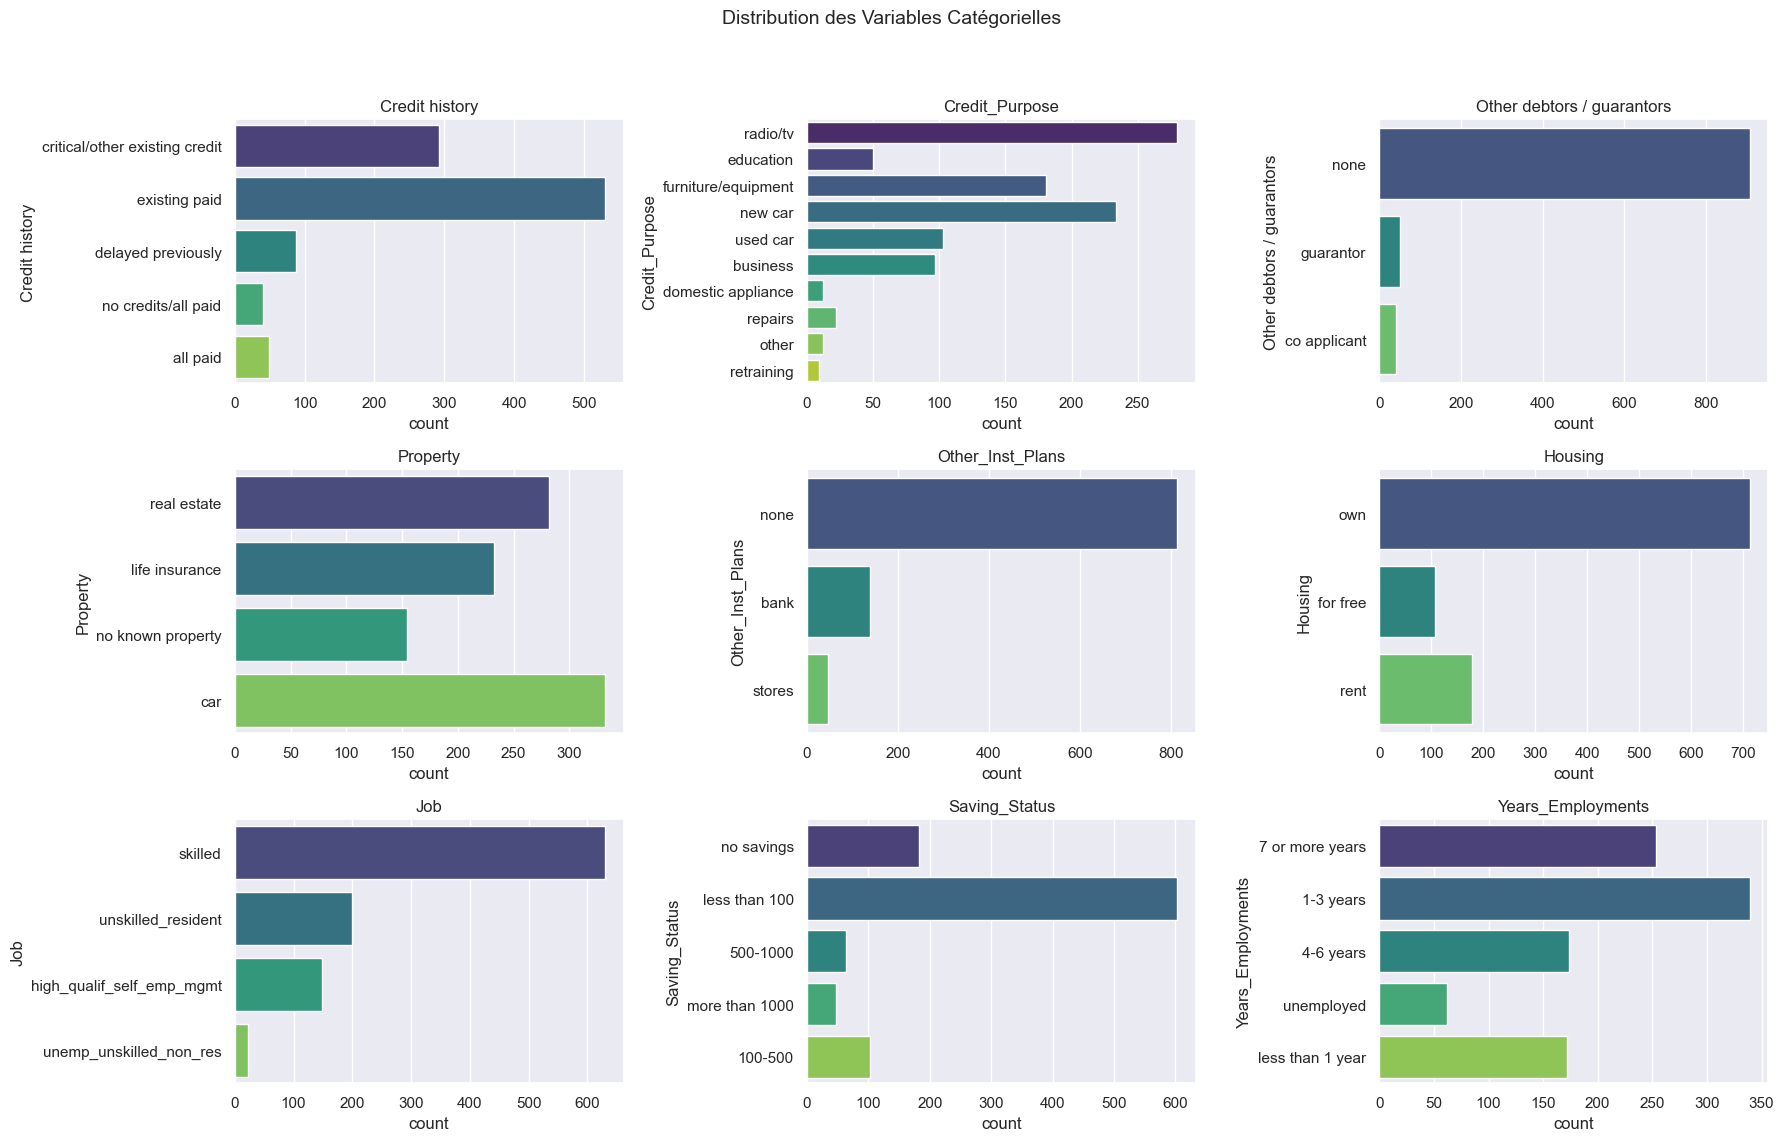

In [19]:
# Sélection des variables catégorielles (excluant la cible)
cat_vars = ["Credit history", "Credit_Purpose", "Other debtors / guarantors", "Property", "Other_Inst_Plans",
            "Housing", "Job", "Saving_Status", "Years_Employments"]

# Affichage des distributions des variables catégorielles
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
fig.suptitle("Distribution des Variables Catégorielles", fontsize=14)

for i, var in enumerate(cat_vars):
    sns.countplot(y=df[var], palette="viridis", ax=axes[i // 3, i % 3])
    axes[i // 3, i % 3].set_title(var)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Analyse Bivarié 

**La variable cible `Checking_Account_statut` vs les varaibles numériques**

In [35]:
df.groupby('Checking_Account_Status').median(numeric_only=True)

,Durations,Credit amount,Installment_Rate_Percent,Residence_Years,Age in years,Num_Existing_Credits,Liable_People
Checking_Account_Status,,,,,,,
bad,24.0,2574.5,4.0,3.0,31.0,1.0,1.0
good,18.0,2244.0,3.0,3.0,34.0,1.0,1.0


**Analyse de l'influence des variables catégorielles sur la cible**

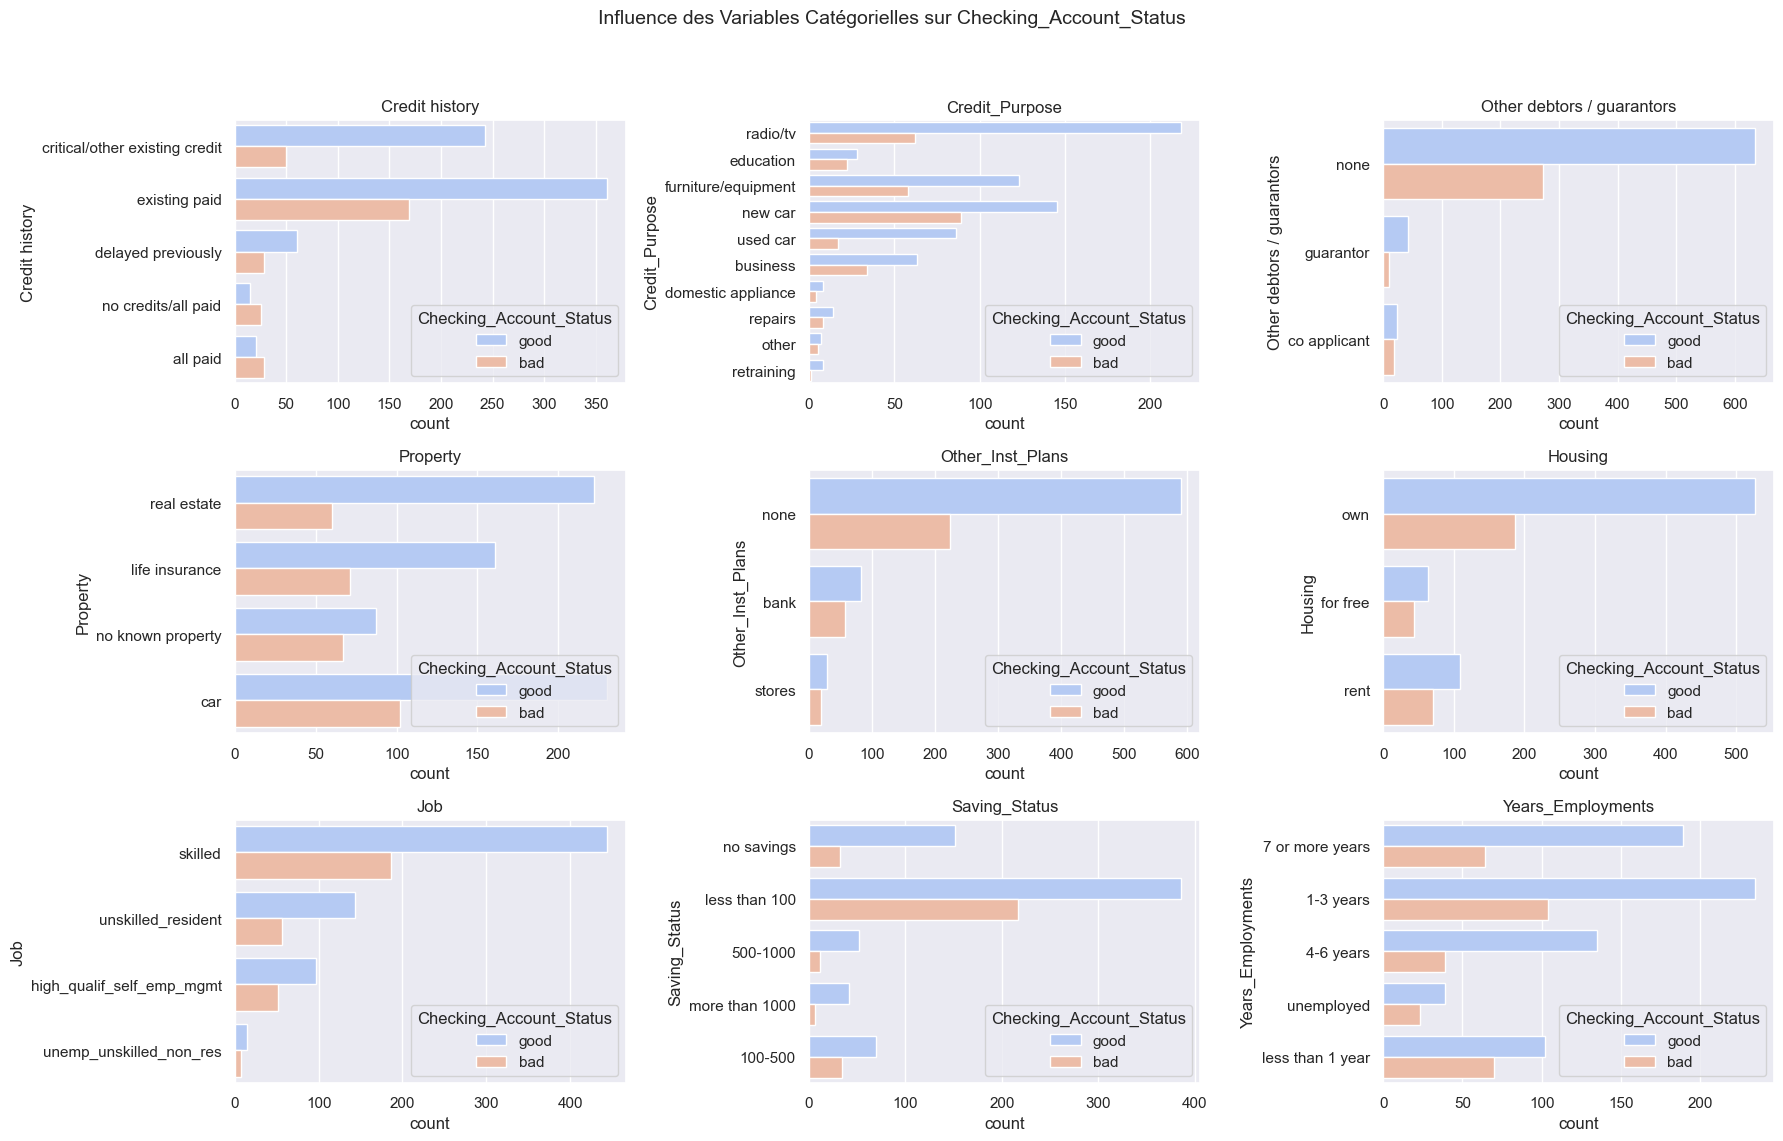

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
fig.suptitle("Influence des Variables Catégorielles sur Checking_Account_Status", fontsize=14)

for i, var in enumerate(cat_vars):
    sns.countplot(y=df[var], hue=df["Checking_Account_Status"], palette="coolwarm", ax=axes[i // 3, i % 3])
    axes[i // 3, i % 3].set_title(var)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

 - "Credit history" : Les clients ayant un historique critique ("critical/other existing credit") sont majoritairement classés "Bad".
 - "Credit Purpose" : Certains motifs de prêt (ex : nouvelle voiture, éducation) semblent plus associés aux clients "Bad" que d’autres.
 - "Other debtors/guarantors" : Les clients ayant un garant ont une répartition plus équilibrée entre "Good" et "Bad", contrairement à ceux sans garant.

- "Housing" : Les propriétaires semblent être moins à risque ("Good"), tandis que les locataires ont une proportion plus élevée de "Bad".

- "Years of Employment" : Les clients ayant peu d’expérience professionnelle (0-1 ans) ont une plus grande probabilité d’être "Bad".

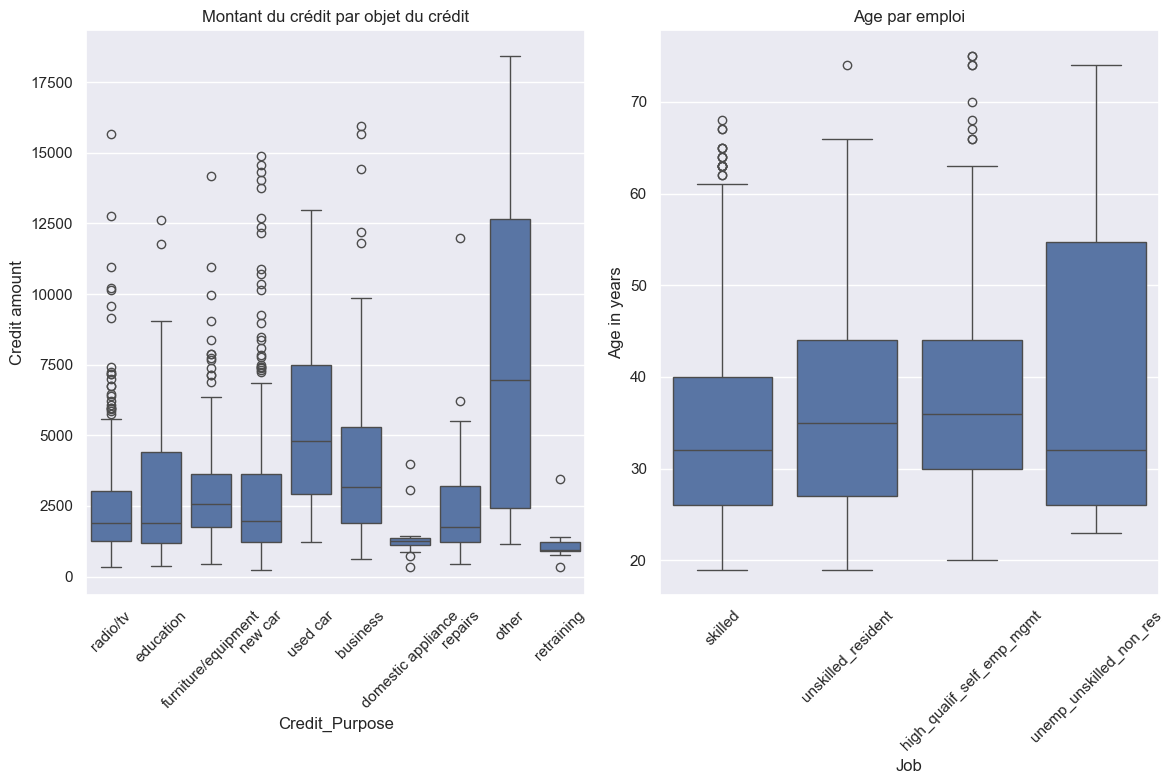

In [24]:
plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
sns.boxplot(x='Credit_Purpose', y='Credit amount', data=df)
plt.title('Montant du crédit par objet du crédit')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.boxplot(x='Job', y='Age in years', data=df)
plt.title('Age par emploi')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

**Montant du crédit par objet du crédit**

On observe :
- Une forte variabilité du montant du crédit selon l'objectif.
- Les crédits les plus élevés semble être associés aux catégories *business* et *other*, qui présentent de grandes médianes et des valeurs extrêmes élevées.
- Certaines catégories comme *domestic appliance* et *retraining* ont des montants de crédit beaucoup plus faibles en moyenne.
- il y a de nombreux outliers (points en dehors des moustaches), indiquant qu'il existe quelques prêts très élevés par rapport à la majorité des observations.

**Âge par type d'emploi** (Graphique de droite)

- Les personnes dans la catégorie "unemp/unskilled non res" semblent être plus âgées en moyenne, avec une mediane plus haute et une forte dispersion des âges.
- Les "skilled workers et unskilled residents"  ont une distribution d'âge resserrée.
- Plusieurs outliers, en particulier pour les travailleurs qualifiés et les employés hautement qualifiés.

en somme:

Le montant du crédit accordés pour les affaires (business) et les autres (other) sont en moyenne plus élevés, tandis que ceux pour les appareils
domestiques et la formation sont plus faibles.

Les travailleurs non qualifiés ou au chômage semblent être plus âgés en moyenne, ce qui pourrait indiquer une plus grande difficulté d'accès à l'emploi pour les personnes plus âgées.

**Boxplot du montant du crédit par Checking_Account_Status**

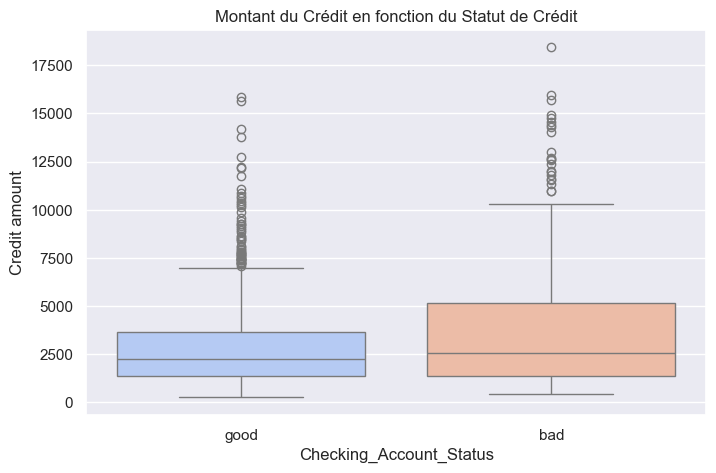

In [25]:

plt.figure(figsize=(8, 5))
sns.boxplot(x=df["Checking_Account_Status"], y=df["Credit amount"], palette="coolwarm")
plt.title("Montant du Crédit en fonction du Statut de Crédit")
plt.xlabel("Checking_Account_Status")
plt.ylabel("Credit amount")
plt.show()

Ce graphique montre un boxplot qui compare le montant du crédit en fonction du statut du compte courant.

- les individus ayant "good" ont une mediane de montant de crédit légèrement plus élevée que ceux ayant un statut "bad" cependant les distributions restent globalement proches.

- Les individus avec un statut de crédit "good" ont généralement accès à des montants de crédit plus élevés et plus variés
- tandis que les individus ayant le statut "bad" semblent plus restreints en termes de montant de prêt.

**Distribution de l'âge selon Checking_Account_Status (KDE Plot)**

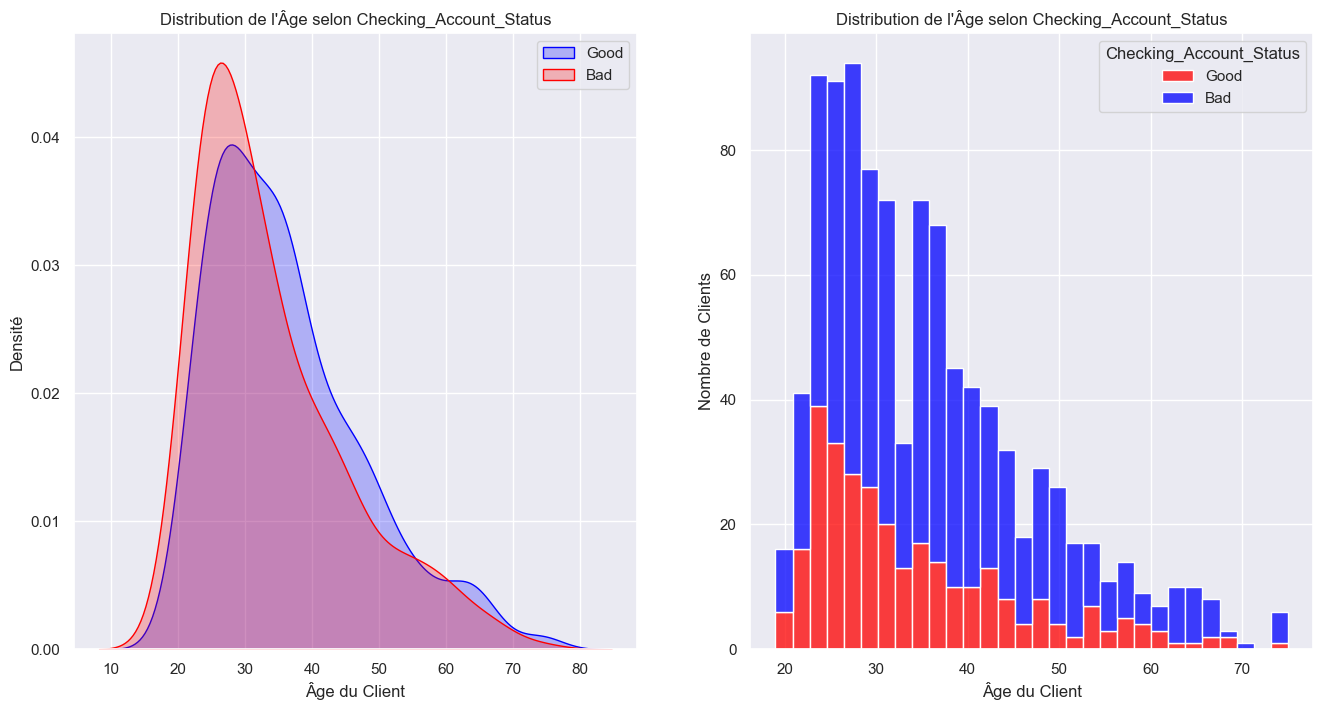

In [27]:
plt.figure(figsize=(16, 8))

#plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
sns.kdeplot(df[df["Checking_Account_Status"] == "good"]["Age in years"], fill=True, label="Good", color="blue")
sns.kdeplot(df[df["Checking_Account_Status"] == "bad"]["Age in years"], fill=True, label="Bad", color="red")
plt.title("Distribution de l'Âge selon Checking_Account_Status")
plt.xlabel("Âge du Client")
plt.ylabel("Densité")
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(df, x="Age in years", hue="Checking_Account_Status", multiple="stack", bins=30, palette=["blue", "red"])
plt.title("Distribution de l'Âge selon Checking_Account_Status")
plt.xlabel("Âge du Client")
plt.ylabel("Nombre de Clients")
plt.legend(title="Checking_Account_Status", labels=["Good", "Bad"])

plt.show()

- La majorité des clients ont entre 20 et 50 ans.
- Les clients "Bad" sont plus présents entre 20 et 40 ans, ce qui pourrait indiquer un risque plus élevé pour les jeunes emprunteurs.
- Au-delà de 50 ans, la proportion de clients "Bad" diminue, suggérant que les emprunteurs plus âgés sont plus stables financièrement.

**Scatter plot entre "Credit amount" et "Durations" coloré par Checking_Account_Status**

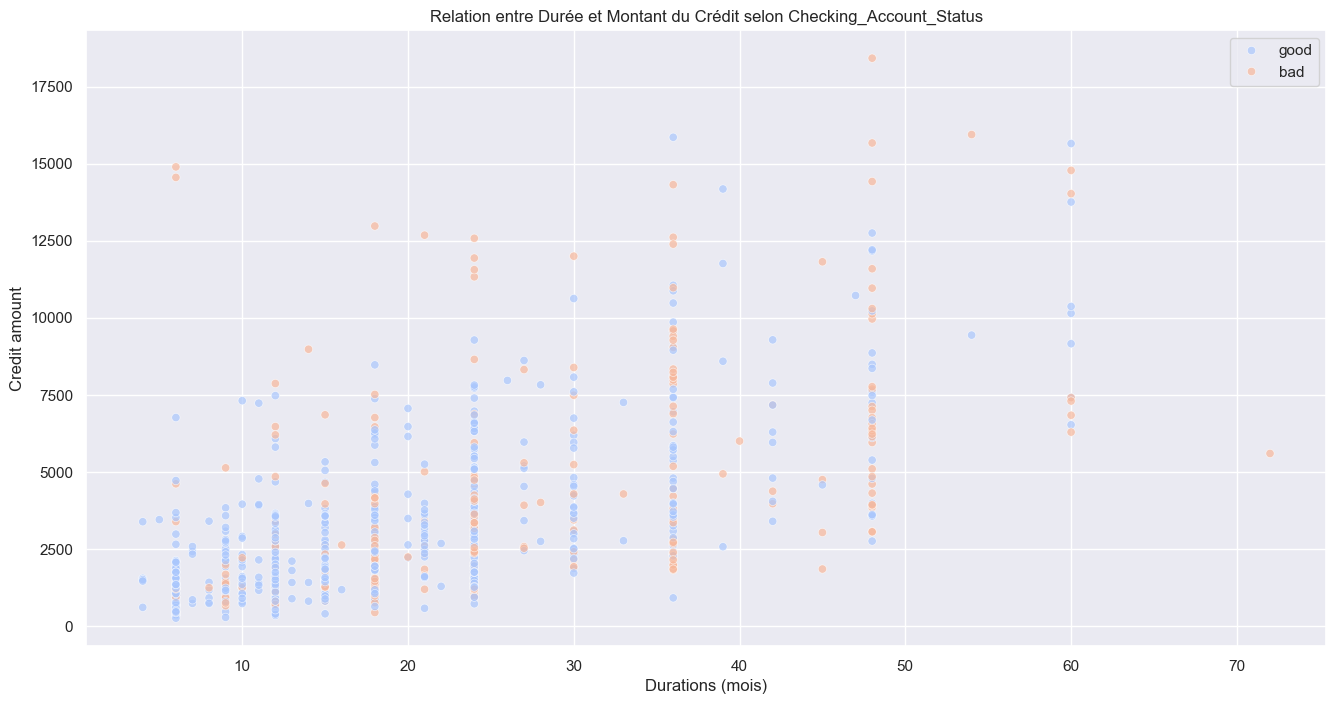

In [29]:
plt.figure(figsize=(16, 8))
sns.scatterplot(x=df["Durations"], y=df["Credit amount"], hue=df["Checking_Account_Status"], palette="coolwarm", alpha=0.7)
plt.title("Relation entre Durée et Montant du Crédit selon Checking_Account_Status")
plt.xlabel("Durations (mois)")
plt.ylabel("Credit amount")
plt.legend()
plt.show()

**Relation entre Durée et Montant du Crédit selon Checking_Account_Status**  

On observe:
- une correlationn positive entre durée et montant du crédit (les crédits plus longs ont tendance à avoir des montants plus élevés, même si nous avons des crédits de courte durée avec des montants importants.)

- bonne repartition entre "good" et "bad" entre le credit compris entre 5 et 10 000 unités monétaires mais des crédits supérieur à 15k unités monétaires sont principalement en statut "good".

1. les crédits plus longs sont souvent associés à des montants plus élevés, probablement enn raison des capacités de remboursement.
2. Les emprunteurs avec un statut "bad" semblent limités en durée et montant, ce qui pourrait refléter des critères de risque bancaire stricts.


**Âge et Le montant du crédit**

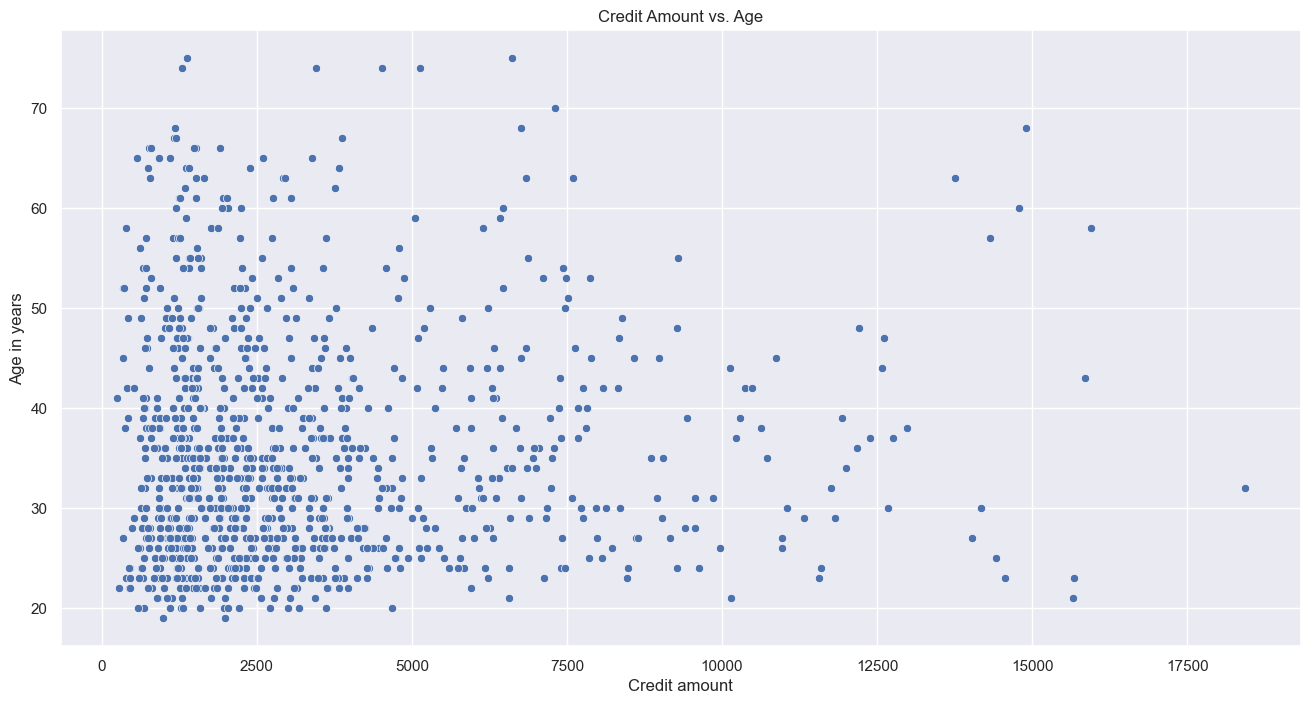

In [31]:
plt.figure(figsize=(16, 8))
sns.scatterplot(x='Credit amount', y='Age in years', data=df)
plt.title('Credit Amount vs. Age')
plt.show()

- Les jeunes, adultes sont les principaux demandeurs de credits, avec une concentration importante autour de montants faibles.
- Les crédits élevés sont plus rares mais repartis sur différents groupes d'âges.
- Les personnes âgees semblent demander moins de crédits, ce qui peut être dû à une moindre nécessité d'emprunter ou à des restrictions bancaires

### Corrélation 

**Matrice de corrélation pour les variables numériques**

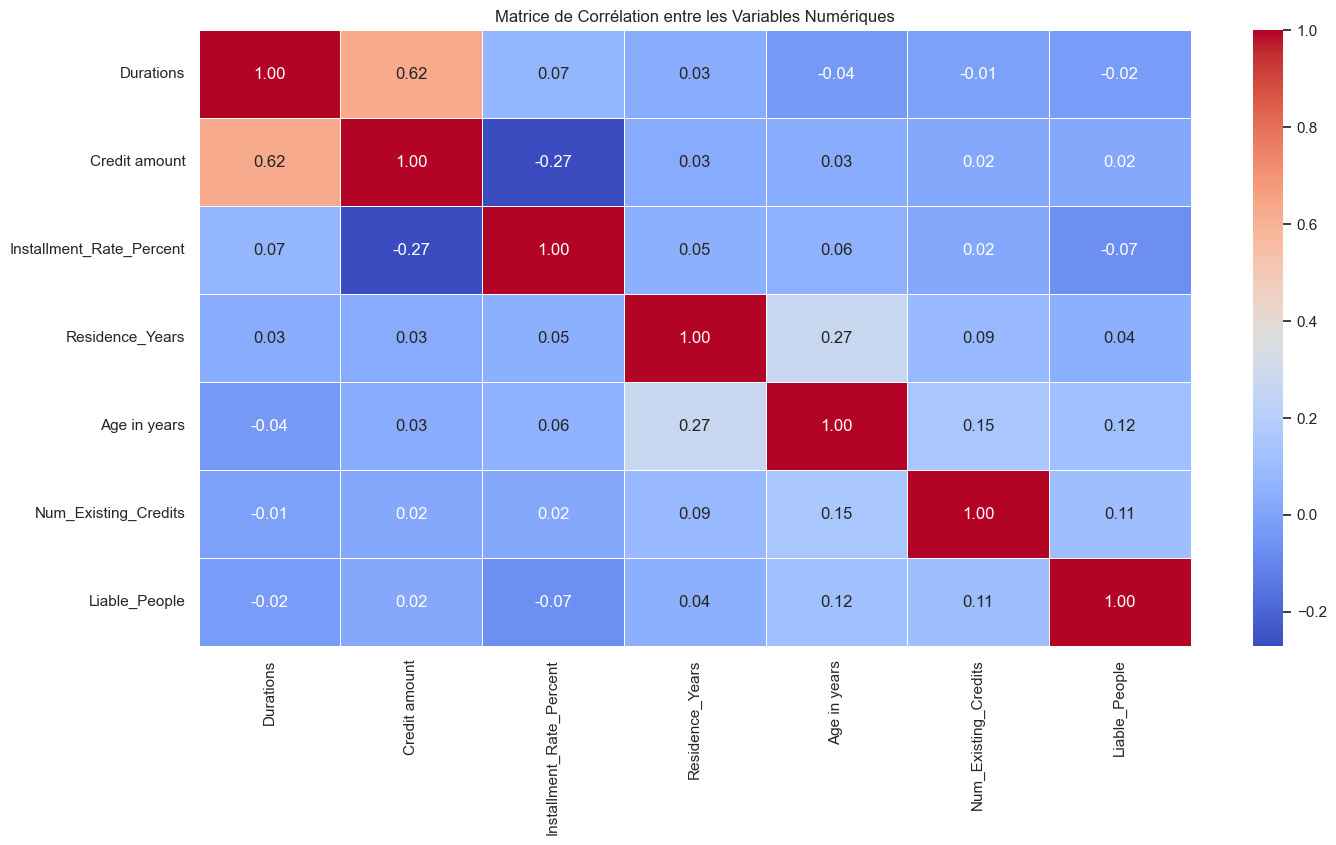

In [32]:
plt.figure(figsize=(16, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matrice de Corrélation entre les Variables Numériques")
plt.show()

-  **Credit amount** et **Duration** ont une corrélation positive → Plus un prêt est long, plus son montant est élevé.

- **Age in years** n’a pas de forte corrélation avec les autres variables, ce qui suggère qu’il doit être analysé indépendamment.

- **Num_Existing_Credits** et **Residence_Years** ont une corrélation modérée,



**Matrice de corrélation pour les variables numériques**

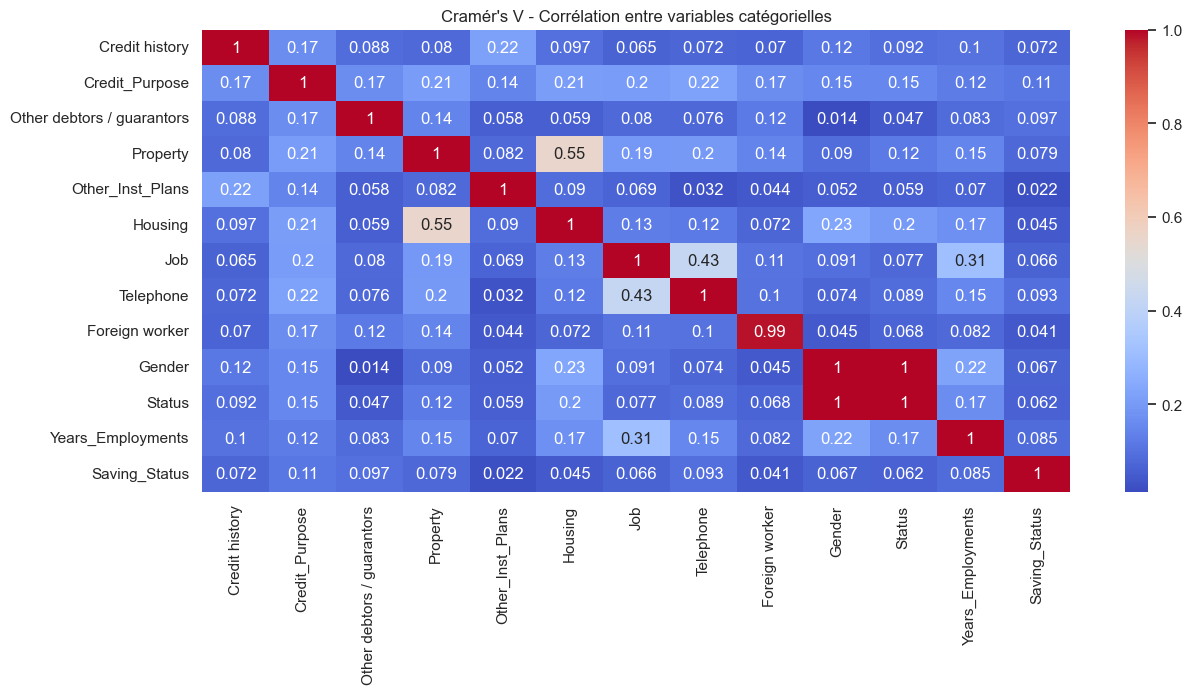

In [33]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k-1, r-1)) if min(k-1, r-1) > 0 else 0

def cramers_v_matrix(df_cat):
    cols = df_cat.columns
    matrix = pd.DataFrame(index=cols, columns=cols)
    for col1 in cols:
        for col2 in cols:
            matrix.loc[col1, col2] = cramers_v(df_cat[col1], df_cat[col2])
    return matrix.astype(float)

# Supposons que ce sont tes colonnes catégorielles :
#cat_cols = ['Credit history', 'Purpose', 'Housing']
cat_cols = ["Credit history", "Credit_Purpose", "Other debtors / guarantors","Property", "Other_Inst_Plans",
 "Housing", "Job", "Telephone","Foreign worker", "Gender", "Status", "Years_Employments", "Saving_Status"]
cramers_matrix = cramers_v_matrix(df[cat_cols])

# Visualisation
plt.figure(figsize=(14,6))
sns.heatmap(cramers_matrix, annot=True, cmap='coolwarm')
plt.title("Cramér's V - Corrélation entre variables catégorielles")
plt.show()


On peut définir un seuil de corrélation à **0.4** (Cramér’s V) pour détecter des relations fortes entre variables. Si deux variables sont très corrélées, on peut supprimer l’une des deux, idéalement celle :

- qui est moins pertinente d’un point de vue métier,

- ou qui a une faible variabilité,

- ou dont l’impact est moins intuitif/interprétable.


Variables à supprimer (proposition) :
Gender ou Foreign worker

Cramér’s V = 0.99

→ Supprime Gender, souvent moins informatif dans un contexte de scoring (et parfois éthiquement sensible).

Telephone ou Job

Cramér’s V = 0.43

→ Supprime Telephone, souvent binaire et moins informatif que la variable Job.

Housing ou Job

Cramér’s V = 0.32

→ Garde Job, supprime Housing si tu dois encore en supprimer une.

Résumé :
Tu peux envisager de supprimer les variables suivantes :

- Gender

- Telephone

- Housing

In [34]:
# Définir les variables et les actions associées
variables = [
    'Foreign worker',
    'Telephone',
    'Gender',
    'Job',
    'Status',
    'Years_Employments',
    'Saving_Status'
]

actions = [
    'Supprimer',
    'Supprimer',
    'Supprimer (corrélée à Foreign)',
    'Regrouper modalités',
    'Regrouper modalités',
    'Regrouper modalités',
    'Regrouper modalités'
]

# Créer le DataFrame
table = pd.DataFrame({
    'Variable': variables,
    'Action': actions
})

table

,Variable,Action
0,Foreign worker,Supprimer
1,Telephone,Supprimer
2,Gender,Supprimer (corrélée à Foreign)
3,Job,Regrouper modalités
4,Status,Regrouper modalités
5,Years_Employments,Regrouper modalités
6,Saving_Status,Regrouper modalités
